In [1]:
import numpy as np
import pandas as pd
from datetime import date
import plotly.express as px
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt
from sklearn import preprocessing as pp
import matplotlib as mpl
from sklearn.decomposition import PCA
from pandas.plotting import lag_plot, autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf 
import statsmodels.api as smw
from datetime import timedelta
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.svm import SVR
from sklearn.metrics import r2_score
# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
tf.__version__
from utils.dde_preprocessing_utils import (set_timestamp_index,
remove_duplicates,
remove_columns,
extract_correlations,
prepare_data_sarimax,
create_test_train_split,
create_sarimax_test_train_split,
create_eval_df,
convert_to_sample_time_feature)
from utils.dde_plotting_utils import(
display_double_timestamps,
display_seasonal_decomposition,
plot_predictions,
plot_accuracy,
plot_error_variations,
plot_learning_curves,
)
%load_ext skip_kernel_extension

In [2]:
SKIP_RETRAIN_RNN = False


## Loading Data

In [3]:
combined_df = pd.read_csv("preprocessed_data.csv")
combined_df = set_timestamp_index(combined_df,"Unnamed: 0")

In [4]:
combined_df

,temp,pressure,humidity,wind_speed,wind_deg,generation biomass,generation fossil brown coal/lignite,generation fossil gas,generation fossil hard coal,generation fossil oil,...,generation solar,generation waste,generation wind onshore,total load actual,price actual,generation,energy_difference,month,day,weekend
2015-01-01 00:00:00+01:00,-2.675,1001.0,77,1.0,62,447.0,329.0,4844.0,4821.0,162.0,...,49.0,196.0,6378.0,25385.0,65.41,28251.0,2866.0,1,1,0
2015-01-01 01:00:00+01:00,-2.675,1001.0,77,1.0,62,449.0,328.0,5196.0,4755.0,158.0,...,50.0,195.0,5890.0,24382.0,64.92,27818.0,3436.0,1,1,0
2015-01-01 02:00:00+01:00,-3.464,1002.0,78,0.0,23,448.0,323.0,4857.0,4581.0,157.0,...,50.0,196.0,5461.0,22734.0,64.48,26796.0,4062.0,1,1,0
2015-01-01 03:00:00+01:00,-3.464,1002.0,78,0.0,23,438.0,254.0,4314.0,4131.0,160.0,...,50.0,191.0,5238.0,21286.0,59.32,25223.0,3937.0,1,1,0
2015-01-01 04:00:00+01:00,-3.464,1002.0,78,0.0,23,428.0,187.0,4130.0,3840.0,156.0,...,42.0,189.0,4935.0,20264.0,56.04,24620.0,4356.0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-31 19:00:00+01:00,12.490,1028.0,62,2.0,140,297.0,0.0,7634.0,2628.0,178.0,...,85.0,277.0,3113.0,30653.0,77.02,26415.0,-4238.0,12,31,0
2018-12-31 20:00:00+01:00,9.990,1029.0,71,1.0,242,296.0,0.0,7241.0,2566.0,174.0,...,33.0,280.0,3288.0,29735.0,76.16,25213.0,-4522.0,12,31,0
2018-12-31 21:00:00+01:00,8.510,1029.0,81,3.0,300,292.0,0.0,7025.0,2422.0,168.0,...,31.0,286.0,3503.0,28071.0,74.30,23987.0,-4084.0,12,31,0
2018-12-31 22:00:00+01:00,6.990,1029.0,81,2.0,310,293.0,0.0,6562.0,2293.0,163.0,...,31.0,287.0,3586.0,25801.0,69.89,22748.0,-3053.0,12,31,0


# RNN

Scale the input data

In [5]:
#Rescaling the data
scaled_df = combined_df.copy(deep=True)
featuresToScale = scaled_df.columns
sX = pp.StandardScaler(copy=True)
scaled_df.loc[:,featuresToScale] = sX.fit_transform(scaled_df[featuresToScale])

Create Train Validation Test Split

In [6]:
train_start = '2015-01-01'
validation_start = '2017-01-01'
test_start = '2017-03-01'
test_end = '2017-03-06'
feature = 'total load actual'
feature_df = combined_df[[feature]]
data_x_train0,data_x_val0,data_x_test0,data_y_train0,data_y_val0,data_y_test0 = create_test_train_split(scaled_df,feature_df,train_start,test_start,test_end,validation_start=validation_start)


Convert to (sample,timestep,feature) format

In [7]:
data_x_train,data_y_train,idx_train = convert_to_sample_time_feature(data_x_train0,data_y_train0,24,1,32)
data_x_test,data_y_test,idx_test = convert_to_sample_time_feature(data_x_test0,data_y_test0,24,1,32)
data_x_val,data_y_val,idx_val = convert_to_sample_time_feature(data_x_val0,data_y_val0,24,1,32)


In [8]:
print(data_x_train.shape,data_y_train.shape)
print(data_x_val.shape,data_y_val.shape)
print(data_x_test.shape,data_y_test.shape)

(17510, 24, 26) (17510, 1)
(1382, 24, 26) (1382, 1)
(70, 24, 26) (70, 1)


Define RNN Model

In [9]:
def build_model_RNN(data_x_train,data_y_train):
  n_timesteps, n_features, n_outputs = data_x_train.shape[1], data_x_train.shape[2], data_y_train.shape[1]
  model = models.Sequential([
  layers.SimpleRNN(32, return_sequences=True,input_shape=(None, n_features), stateful=False), 
  layers.BatchNormalization(),
  layers.SimpleRNN(32, return_sequences=True, stateful=False),
  layers.BatchNormalization(),
  layers.SimpleRNN(32, stateful=False),
  layers.BatchNormalization(),
  layers.Dense(n_outputs)                     
  ])
  model.compile(optimizer='Adam',loss='mse',metrics='mae') 
  return model

Define Callback functions

In [10]:
myCheckpointRNN= keras.callbacks.ModelCheckpoint("./RNN/my_best_RNN_model.h5", save_best_only=True)
myEarly_stoppingRNN = keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True)

Hyperparameters

In [11]:
num_epochs = 150
batch_size = 32

Training the Model

In [12]:
%%skip $SKIP_RETRAIN_RNN

model_rnn = build_model_RNN(data_x_train,data_y_train)
history_rnn = model_rnn.fit(data_x_train, data_y_train, epochs=num_epochs, batch_size=batch_size, validation_data=(data_x_val, data_y_val) , 
                                 callbacks=[myCheckpointRNN,myEarly_stoppingRNN])#, verbose=0)



Epoch 1/150
548/548 [==============================] - 27s 45ms/step - loss: 828875392.0000 - mae: 28433.3750 - val_loss: 905632704.0000 - val_mae: 29682.7754
Epoch 2/150
548/548 [==============================] - 25s 45ms/step - loss: 825605952.0000 - mae: 28387.0352 - val_loss: 899147968.0000 - val_mae: 29588.7324
Epoch 3/150
548/548 [==============================] - 25s 46ms/step - loss: 819672896.0000 - mae: 28299.1836 - val_loss: 890919040.0000 - val_mae: 29471.5430
Epoch 4/150
548/548 [==============================] - 25s 45ms/step - loss: 811508288.0000 - mae: 28175.8945 - val_loss: 877644864.0000 - val_mae: 29271.7578
Epoch 5/150
548/548 [==============================] - 23s 42ms/step - loss: 801502848.0000 - mae: 28022.0410 - val_loss: 862249280.0000 - val_mae: 29038.0547
Epoch 6/150
548/548 [==============================] - 23s 42ms/step - loss: 789909504.0000 - mae: 27841.0430 - val_loss: 847335744.0000 - val_mae: 28813.3516
Epoch 7/150
548/548 [=========================

Evaluate the training process

In [13]:
%%skip $SKIP_RETRAIN_RNN
histRNN = pd.DataFrame(history_rnn.history)
histRNN['epoch'] = history_rnn.epoch

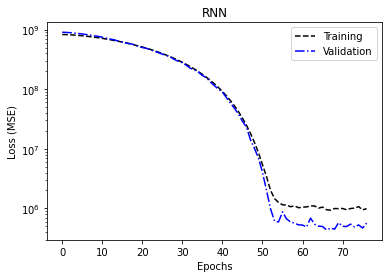

In [14]:
%%skip $SKIP_RETRAIN_RNN
# Plotting the results:
# Remember that we defined our loss as MSE in the model.
fig = plot_learning_curves(histRNN,'RNN',"./RNN/learningcurve_RNN.png")

Load best model

In [15]:
#Calling back the best model:
model_best_RNN = keras.models.load_model("./RNN/my_best_RNN_model.h5")
model_best_RNN.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, None, 32)          1888      
_________________________________________________________________
batch_normalization (BatchNo (None, None, 32)          128       
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, None, 32)          2080      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 32)          128       
_________________________________________________________________
simple_rnn_2 (SimpleRNN)     (None, 32)                2080      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 1)                 3

Evaluate predictions

In [16]:
#Label and indices:
#Since we have shifted the data by 4 width windows, initial label DF is to be filtered.
y_test_filtered = data_y_test0.loc[idx_test]
y_test_filtered = y_test_filtered.squeeze(axis=1)
Y_test_predictions = pd.Series(model_best_RNN.predict(data_x_test).flatten(),index=y_test_filtered.index)

In [17]:
eval_df = create_eval_df(Y_test_predictions,y_test_filtered)

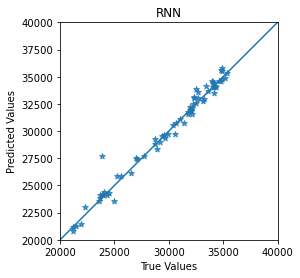

In [18]:
fig = plot_accuracy(eval_df,'RNN',"./RNN/accuracy_RNN.png")

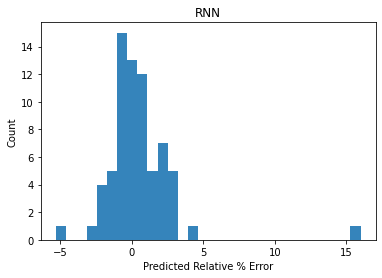

In [19]:
fig = plot_error_variations(eval_df,'RNN',"./RNN/error_variations_RNN.png")

In [20]:
#Calculating the mean absolutepercentage error:
abs_error_rnn = abs(Y_test_predictions - y_test_filtered)/y_test_filtered*100
np.average(abs_error_rnn)

1.4054912751853301

In [21]:
#Calculating R2 value:
r2_test = r2_score(y_test_filtered, Y_test_predictions)
print('R^2 score is  %3.2f' %r2_test)

R^2 score is  0.98


<ipython-input-22-eb7f14214c10>:2: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


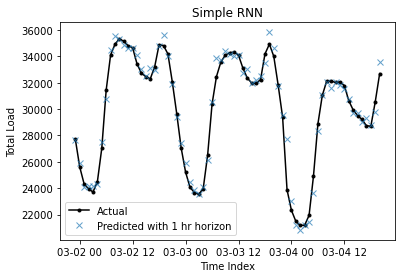

In [22]:
fig = plot_predictions(eval_df,1,'Simple RNN', 'Total Load',"./RNN/predictions_RNN.png")
fig.show()